# Part 2: SUCCESOR LEARNING

Hwajin Shin, Lucia Gonzalez Anton

Part 2.1: Random walk

In [2]:
# add imports
import numpy as np
import matplotlib.pyplot as plt

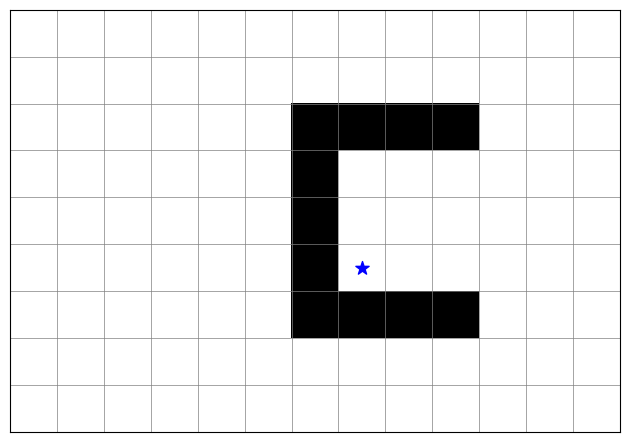

In [2]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (5, 7)

def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

plot_maze(maze)
plt.scatter(start[1], start[0], marker='*', color='blue', s=100)
plt.tight_layout()
# plt.savefig('maze.png')
plt.show()

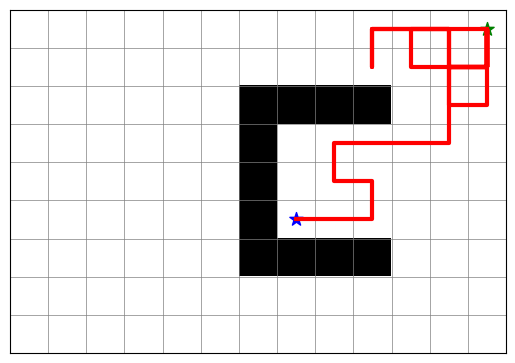

In [ ]:
#Implement random walk

def random_walk(maze, start, n_steps):
    # Initialize list to store positions
    positions = [start]

    # Define possible moves as (row change, col change)
    moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right

    current_pos = start

    for _ in range(n_steps):
        valid_move = False
        while not valid_move:
            # Pick a random move
            move = moves[np.random.randint(0, 4)] #randomly pick any of the 4 possible moves
            new_pos = (current_pos[0] + move[0], current_pos[1] + move[1]) #update position for row and col

            # Check if new position is within bounds and not a wall
            if (0 <= new_pos[0] < maze.shape[0] and #row
                0 <= new_pos[1] < maze.shape[1] and #col
                maze[new_pos] == 0):
                valid_move = True
                positions.append(new_pos)
                current_pos = new_pos

    return positions

def plot_path(maze, path):
    # Plot a maze and a path in it
    plot_maze(maze)
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], c='red', lw=3) #plot path as a red line
    plt.scatter(path[0, 1], path[0, 0], marker='*', color='blue', s=100)
    plt.scatter(path[-1, 1], path[-1, 0], marker='*', color='green', s=100) #end of path array as a green star
    plt.show()

# Plot a random path
path = random_walk(maze, start, 40)
plot_path(maze, path)

Part 2.2: Update the SR matrix of the starting state discounting future states

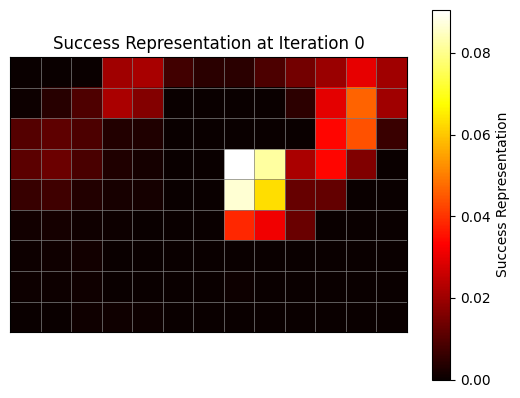

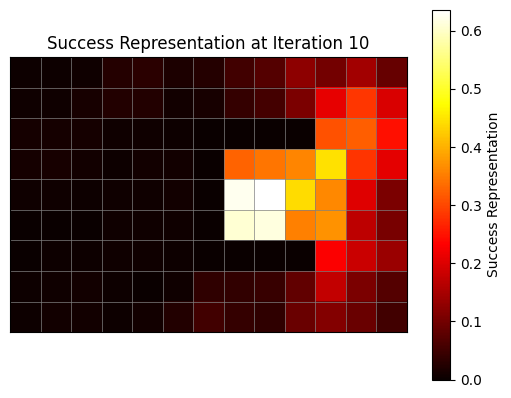

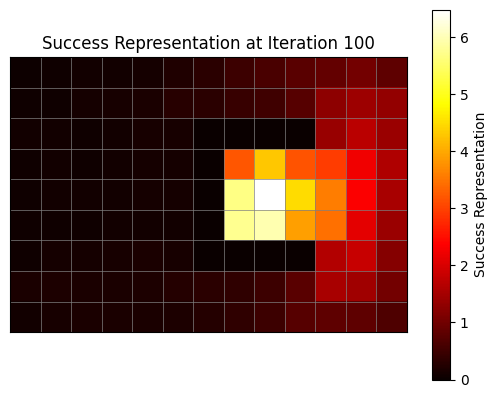

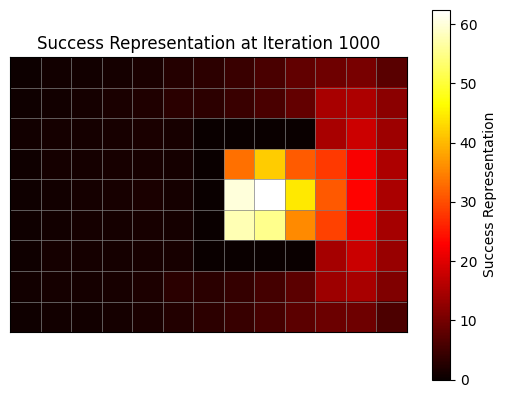

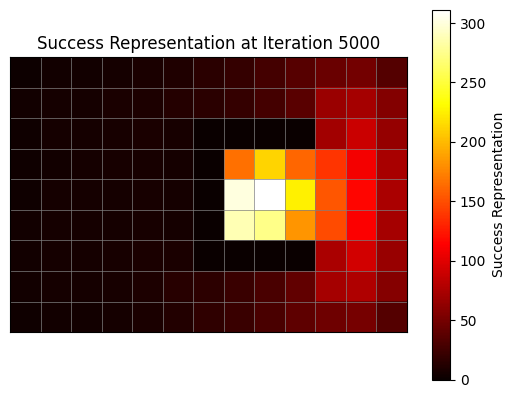

In [5]:
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.02):
    """
    Update the successor representation for the starting state of the trajectory using the provided example trajectory.
    The successor representation matrix is updated by discounting future states appropriately.

    Args:
        succ_repr (numpy array): Current state of the successor representation (matrix).
        trajectory (list): A list of positions (state coordinates) visited during the trajectory.
        gamma (float): Discount factor (0 <= gamma < 1).
        alpha (float): Learning rate (0 <= alpha <= 1).
    
    Returns:
        numpy array: Updated successor representation.
    """
    # Get the starting state from the trajectory (this is the state to learn from)
    start_state = trajectory[0]
    
    # Iterate over the trajectory, updating the successor representation
    for t, state in enumerate(trajectory):
        # Calculate the discounted future for this state
        discount = gamma ** t  # The discount factor for this state
        
        # Update the SR for the state by adding the discounted value
        succ_repr[state] += alpha * discount

        # exponential decrease by multiplying by discount factor
    
    return succ_repr

# initialize successor representation
succ_repr = np.zeros_like(maze)

# sample a whole bunch of trajectories (reduce this number if this code takes too long, but it shouldn't take longer than a minute with reasonable code)
for i in range(5001):
    # sample a path (we use 340 steps here to sample states until the discounting becomes very small)
    path = random_walk(maze, start, 340)
    # update the successor representation
    succ_repr = learn_from_traj(succ_repr, path, alpha=0.02)  # choose a small learning rate

    if i in [0, 10, 100, 1000, 5000]:  # Specify which iterations you want to plot
        plot_maze(maze)  # Your function to plot the maze
        
        # Plot the success representation as an image
        plt.imshow(succ_repr, cmap='hot')
        plt.colorbar(label="Success Representation")  # Add color legend
        
        # Add a title to the plot based on the iteration number
        plt.title(f"Success Representation at Iteration {i}")
        
        # If you want to save the plot only at specific iterations
        # if i == 5000:
        #     plt.savefig("empirical")

        # Show the plot
        plt.show()

#print(succ_repr)

Progression Over Iterations: As the agent (through random walk) explores the maze and updates its successor representation, you will see that the regions that are more frequently visited or are in the "future path" of the agent get brighter, showing higher values. Over time, areas the agent visits early in its random walk will accumulate higher values (indicating they are more "successful" in the sense of being visited frequently or in the future).

The SR is a matrix that encodes how likely it is that a particular state will be visited in the future, starting from some initial state. It represents the expected future behavior of an agent when it begins its trajectory in any given state.

As the agent moves through the trajectory, the future states that it visits become progressively less relevant (in terms of how much they should impact the current state's SR): discount factor (gamma).

High gamma (close to 1): Future states are not heavily discounted and have almost the same weight as immediate states.
Low gamma (close to 0): Future states are much less important in updating the current state's SR.

Part 2.3: Compute the overall transition matrix

In [6]:
def compute_transition_matrix(maze):
    # Get maze dimensions
    num_rows, num_cols = maze.shape
    
    # Total number of states in the grid (flattened)
    num_states = num_rows * num_cols
    
    # Initialize the transition matrix (size num_states x num_states)
    transitions = np.zeros((num_states, num_states))
    
    # Helper function to map 2D coordinates to 1D index
    def to_index(row, col):
        return row * num_cols + col
    
    # Iterate over all grid positions to compute transitions
    for row in range(num_rows):
        for col in range(num_cols):
            if maze[row, col] == 1:  # Wall (no transitions possible)
                continue
            
            # Get the current state index
            current_state = to_index(row, col)
            
            # Collect valid neighbors (up, down, left, right)
            neighbors = []
            if row > 0 and maze[row - 1, col] != 1:  # Up
                neighbors.append((row - 1, col))
            if row < num_rows - 1 and maze[row + 1, col] != 1:  # Down
                neighbors.append((row + 1, col))
            if col > 0 and maze[row, col - 1] != 1:  # Left
                neighbors.append((row, col - 1))
            if col < num_cols - 1 and maze[row, col + 1] != 1:  # Right
                neighbors.append((row, col + 1))
            
            # Number of valid neighbors
            num_neighbors = len(neighbors)
            
            # If there are valid neighbors, distribute transition probabilities equally
            if num_neighbors > 0:
                prob = 1 / num_neighbors  # Uniform probability to each neighbor
                for neighbor in neighbors:
                    neighbor_state = to_index(neighbor[0], neighbor[1])
                    transitions[current_state, neighbor_state] = prob
    
    # Normalize rows so each row sums to 1 (transition probabilities)
    row_sums = transitions.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Prevent division by zero for rows with no transitions
    transitions = transitions / row_sums[:, np.newaxis]
    
    # Remove NaNs (if any exist, after normalization)
    transitions = np.nan_to_num(transitions)  # Replace NaNs with zeros
    
    return transitions

transition_matrix = compute_transition_matrix(maze)

# To visualize or check the transition matrix
print(transition_matrix)
size = np.shape(transition_matrix)
print(size)

[[0.         0.5        0.         ... 0.         0.         0.        ]
 [0.33333333 0.         0.33333333 ... 0.         0.         0.        ]
 [0.         0.33333333 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.33333333 0.        ]
 [0.         0.         0.         ... 0.33333333 0.         0.33333333]
 [0.         0.         0.         ... 0.         0.5        0.        ]]
(117, 117)


Part 2.4: Recompute the successor representation at the starting position by repeatedly
applying the transition matrix you computed

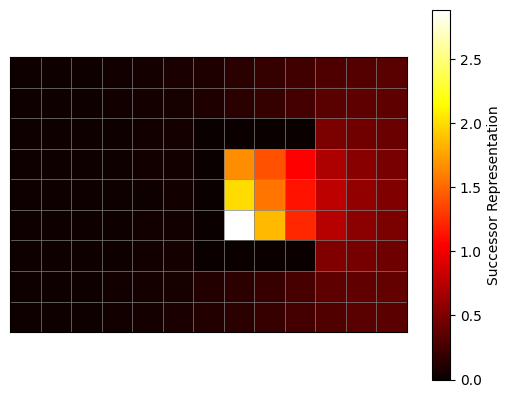

In [7]:
def compute_sr(transitions, i, j, gamma=0.98):
    """
    Compute the successor representation for a given start state (i, j)
    using the transition matrix and discount factor gamma.
    
    Args:
        transitions (numpy array): Transition matrix.
        i (int): Row index of the start state.
        j (int): Column index of the start state.
        gamma (float): Discount factor.
    
    Returns:
        numpy array: Successor representation reshaped to the maze size.
    """
    # Get maze size from transitions
    num_states = transitions.shape[0]
    
    # Initialize the current discounted occupancy vector
    current_discounted_occupancy = np.zeros(num_states)
    
    # Convert the (i, j) start position into its flattened index
    start_index = i * maze.shape[1] + j
    current_discounted_occupancy[start_index] = 1  # Start state is fully occupied initially
    
    # Initialize the total SR vector
    total = np.zeros_like(current_discounted_occupancy)
    
    # Iterate for a number of steps to simulate long-term behavior
    for _ in range(340):
        # Update total SR with current discounted occupancy
        total += current_discounted_occupancy
        
        # Compute next occupancy by applying the transition matrix
        current_discounted_occupancy = gamma * np.dot(transitions, current_discounted_occupancy)
    
    # Reshape the total SR vector back into the maze shape
    return total.reshape(maze.shape)

# Compute state representation for start state
i, j = start
sr = compute_sr(transition_matrix, i, j, gamma=0.98)

# Plot state representation
plot_maze(maze)
plt.imshow(sr, cmap='hot')
plt.colorbar(label="Successor Representation")
# plt.savefig("transition_iterate")
plt.show()

Part 2.5: BONUS

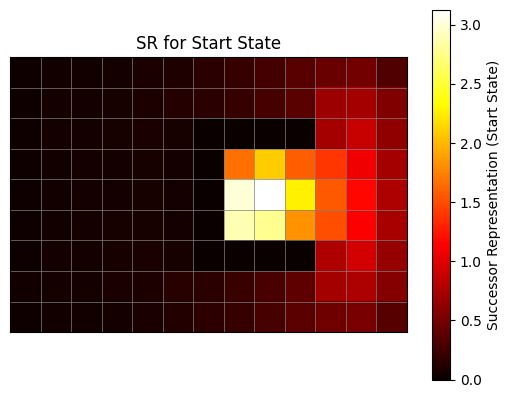

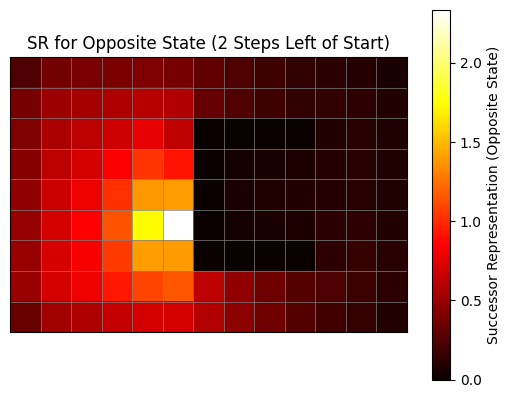

In [ ]:
def compute_sr_analytical(transitions, gamma=0.98):
    """
    Compute the successor representation matrix using the analytical solution.
    
    Args:
        transitions (numpy array): Transition matrix.
        gamma (float): Discount factor.
    
    Returns:
        numpy array: Successor representation matrix.
    """
    num_states = transitions.shape[0]
    identity = np.eye(num_states)
    
    # Compute (I - gamma * T)^(-1)
    sr_matrix = np.linalg.inv(identity - gamma * transitions)
    
    return sr_matrix

# Compute the successor representation for all states
sr_matrix = compute_sr_analytical(transition_matrix, gamma=0.98)

# Extract and plot SR for the start state
start_index = start[0] * maze.shape[1] + start[1]
sr_start = sr_matrix[start_index].reshape(maze.shape)

# Plot SR for the start state
plot_maze(maze)
plt.imshow(sr_start, cmap='hot')
plt.colorbar(label="Successor Representation (Start State)")
plt.title("SR for Start State")
plt.show()

# Extract and plot SR for the state 2 steps to the left of the start
opposite_state = (start[0], start[1] - 2)
opposite_index = opposite_state[0] * maze.shape[1] + opposite_state[1]
sr_opposite = sr_matrix[opposite_index].reshape(maze.shape)

# Plot SR for the opposite state
plot_maze(maze)
plt.imshow(sr_opposite, cmap='hot')
plt.colorbar(label="Successor Representation (Opposite State)")
plt.title("SR for Opposite State (2 Steps Left of Start)")
plt.show()
